<a href="https://colab.research.google.com/github/olaf-ys/Ba820-Group3/blob/main/ba820_proj_AG_news.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AG News - Topic Identification for AG News Corpus**

Team 3 members : Yuanshan Zhang, Yiming Wang, Mengxin Zhao, Jiayun Liu, Yahui Wen

Date: 03/02/2024

# 1.Introduction

## 1.1 Problem definition


Text classification stands as a fundamental topic within the domain of Natural Language Processing (NLP), where the primary task involves allocating predefined labels to free-text documents. In our case, the objective is to identify the category given the title and description of a piece of news.

## 1.2 Motivation

Our motivation stems from our dedication to helping news consumers, journalists, educators, and researchers to navigate news more efficiently, by identifying news articles that are most relevant and reliable across sectors. We aim to build a system that categorizes news with high precision and can extract valuable insights and trends from the news. This would provide convenience and confidence to stakeholders in the news landscape.

## 1.3 Data Description

Our data is archived from the AG News corpus created by Antonio Gull, which consists of online news articles covering the four largest categories. The dataset contains 9 columns, 30,000 training and 1,900 test examples for each class, and includes basic article information such as title, category, source and publication.
The original data source can be accessed [here](https://nlpprogress.com/english/text_classification.html).

# 2.Data Processing

## 2.1 Library Import

In [19]:
# General
import csv
import pandas as pd
import datetime
import numpy as np

# NLP
import re
import spacy

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
from gensim import corpora, models
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from matplotlib.colors import LinearSegmentedColormap
import plotly.express as px
from yellowbrick.cluster import SilhouetteVisualizer

# Sklean
from sklearn.experimental import enable_halving_search_cv
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import normalize, LabelEncoder
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, classification_report, silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

# Model building and tuning
from xgboost import XGBClassifier
from scipy.stats import randint, uniform
from scipy.stats import loguniform
import seaborn as sns


# Deep learning
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# List to hold the corrected data
data = []

# Temporary list to hold fields that span multiple lines
current_fields = []

# Open the file and read line by line
with open('/content/drive/MyDrive/newsSpace.txt', 'r', encoding='ISO-8859-1') as file:
    for line in file:
        # Check if the line ends with a backslash indicating continuation
        if line.endswith('\\\n'):
            # Add the current line's content (except for the backslash and newline) to the current fields
            current_fields.append(line[:-2])
        else:
            # This line does not end with a backslash, so it is the end of the current entry
            # Combine any previously accumulated fields with the current line
            current_fields.append(line)
            full_entry = ''.join(current_fields)

            # Split the full entry into fields using the tab delimiter
            fields = full_entry.rstrip('\n').split('\t')

            # Ensure that each line has the correct number of fields
            if len(fields) == 9:
                data.append(fields)

            # Reset the current fields list for the next entry
            current_fields = []

# Convert the corrected data list to a DataFrame
df = pd.DataFrame(data, columns=['source', 'url', 'title', 'image', 'category', 'description', 'rank', 'pubdate', 'video'])

# Display the first few rows of the DataFrame to ensure correctness
df.head()


,source,url,title,image,category,description,rank,pubdate,video
0,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Wall St. Pullback Reflects Tech Blowout (Reuters),none,Business,"Reuters - Wall Street's long-playing drama,""Wa...",5,0000-00-00 00:00:00,\N
1,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Wall St. Bears Claw Back Into the Black (Reuters),none,Business,"Reuters - Short-sellers, Wall Street's dwindli...",5,0000-00-00 00:00:00,\N
2,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Carlyle Looks Toward Commercial Aerospace (Reu...,none,Business,Reuters - Private investment firm Carlyle Grou...,5,0000-00-00 00:00:00,\N
3,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Oil and Economy Cloud Stocks' Outlook (Reuters),none,Business,Reuters - Soaring crude prices plus worriesabo...,5,0000-00-00 00:00:00,\N
4,Yahoo Business,http://us.rd.yahoo.com/dailynews/rss/business/...,Iraq Halts Oil Exports from Main Southern Pipe...,none,Business,Reuters - Authorities have halted oil exportfl...,5,0000-00-00 00:00:00,\N


In [4]:
# Choose 4 news categories in English, of similar size, and distinguishable categories
sampled_category = ['Business', 'Entertainment', 'Sports', 'Sci/Tech']

lst = []

# Randomly select 5000 samples in each category to ensure sample balance
for i in sampled_category:
  lst.append(df[df['category'] == i].sample(n=5000, random_state=42))

data = pd.concat(lst)

# Keep only the features needed for NLP
data = data[['title', 'description', 'category']]

data['text'] = data['title'] + ' ' + data['description']

data = data[['text', 'category']]

data.head()

,text,category
539103,Microsoft on Sale Mr. Softy lures PeopleSoft c...,Business
436004,IBM &#39;to sell PC business&#39; IBM is repor...,Business
512298,Gartner buys Meta Group Both Gartner and Meta ...,Business
76967,Nikkei Dips for a 2nd Straight Session TOKYO ...,Business
553560,GM Profit Falls on European Losses Here's how...,Business


The reasons we chose these four categories are that they have very similar total news counts and that their topics would be more specialized. Other categories in the corpus with similar news counts are World, Europe, Top News, and Italia. Some of these categories can be extremely hard to classify based on content, and some may not even be in English.

In [5]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Set pandas to display the full content of text columns
pd.set_option('display.max_colwidth', None)

# Define a function to clean the text
def clean_text(text):

    text = re.sub(r'(&#34;|&#[0-9]+;)', '', text)  # Remove HTML entities
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\d+', '', text)  # Remove all digits
    text = re.sub(r'\s+', ' ', text)  # Remove extra white spaces
    text = text.lower()  # Convert to lowercase

    return text

# Apply the cleaning function to the 'text' column
data['cleaned_text'] = data['text'].apply(clean_text)

# Show the first few rows of the cleaned text
data[['text', 'cleaned_text']].head()

,text,cleaned_text
539103,"Microsoft on Sale Mr. Softy lures PeopleSoft customers with deep discounts, but investors shouldn't worry. Much.",microsoft on sale mr softy lures peoplesoft customers with deep discounts but investors shouldnt worry much
436004,IBM &#39;to sell PC business&#39; IBM is reportedly in talks to sell its personal computer business. It would mark the end of an era for the company that brought the computer into the mainstream when it began selling its desktop PC to corporations and consumers in 1981.,ibm to sell pc business ibm is reportedly in talks to sell its personal computer business it would mark the end of an era for the company that brought the computer into the mainstream when it began selling its desktop pc to corporations and consumers in
512298,"Gartner buys Meta Group Both Gartner and Meta Group are headquartered in Stamford so costs related to combining operations should be minimized. Gartner is known to have the largest segment of the research market, a leader in information technology research.",gartner buys meta group both gartner and meta group are headquartered in stamford so costs related to combining operations should be minimized gartner is known to have the largest segment of the research market a leader in information technology research
76967,"Nikkei Dips for a 2nd Straight Session TOKYO (Reuters) - Tokyo's Nikkei fell for a second straight session to close 0.99 percent lower on Tuesday as selling increased after the dollar's retreat below 103 yen, putting more pressure on exporters such as Sony Corp",nikkei dips for a nd straight session tokyo reuters tokyos nikkei fell for a second straight session to close percent lower on tuesday as selling increased after the dollars retreat below yen putting more pressure on exporters such as sony corp
553560,"GM Profit Falls on European Losses Here's how hard it is to navigate today's fickle auto industry: Last year, General Motors Corp. managed to preserve profit in North America, but its market share tumbled. At the same time, GM's share of the European market rose to a five-year high, but the company lost a huge amount of money there.",gm profit falls on european losses heres how hard it is to navigate todays fickle auto industry last year general motors corp managed to preserve profit in north america but its market share tumbled at the same time gms share of the european market rose to a fiveyear high but the company lost a huge amount of money there


## 2.2 Tokenize

In [6]:
# Load the model, disabling unnecessary pipeline components (i.e. dependency parsing and named entity recognition)
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def process_text_list(texts):
    # Process a list of texts in batches using nlp.pipe
    processed_texts = []
    for doc in nlp.pipe(texts, batch_size=50): # use batch training to parallel computation
        # For each doc, extract lemmas of non-stop words
        lemmatized_text = [token.lemma_ for token in doc if not token.is_stop]
        processed_texts.append(lemmatized_text)
    return processed_texts

In [7]:
# apply process_text_list
processed_texts = process_text_list(data['cleaned_text'].tolist())

data['preprocessed_text'] = processed_texts

data[["cleaned_text", "preprocessed_text"]].head()

,cleaned_text,preprocessed_text
539103,microsoft on sale mr softy lures peoplesoft customers with deep discounts but investors shouldnt worry much,"[microsoft, sale, mr, softy, lure, peoplesoft, customer, deep, discount, investor, not, worry]"
436004,ibm to sell pc business ibm is reportedly in talks to sell its personal computer business it would mark the end of an era for the company that brought the computer into the mainstream when it began selling its desktop pc to corporations and consumers in,"[ibm, sell, pc, business, ibm, reportedly, talk, sell, personal, computer, business, mark, end, era, company, bring, computer, mainstream, begin, sell, desktop, pc, corporation, consumer]"
512298,gartner buys meta group both gartner and meta group are headquartered in stamford so costs related to combining operations should be minimized gartner is known to have the largest segment of the research market a leader in information technology research,"[gartner, buy, meta, group, gartner, meta, group, headquarter, stamford, cost, relate, combine, operation, minimize, gartner, know, large, segment, research, market, leader, information, technology, research]"
76967,nikkei dips for a nd straight session tokyo reuters tokyos nikkei fell for a second straight session to close percent lower on tuesday as selling increased after the dollars retreat below yen putting more pressure on exporters such as sony corp,"[nikkei, dip, nd, straight, session, tokyo, reuters, tokyos, nikkei, fall, second, straight, session, close, percent, lower, tuesday, sell, increase, dollar, retreat, yen, put, pressure, exporter, sony, corp]"
553560,gm profit falls on european losses heres how hard it is to navigate todays fickle auto industry last year general motors corp managed to preserve profit in north america but its market share tumbled at the same time gms share of the european market rose to a fiveyear high but the company lost a huge amount of money there,"[gm, profit, fall, european, loss, here, hard, navigate, today, fickle, auto, industry, year, general, motors, corp, manage, preserve, profit, north, america, market, share, tumble, time, gms, share, european, market, rise, fiveyear, high, company, lose, huge, money]"


In [8]:
colors = [(255/255, 182/255, 193/255), (255/255, 192/255, 203/255), (255/255, 105/255, 180/255)]
custom_colormap = LinearSegmentedColormap.from_list('blackpink', colors, N=256)

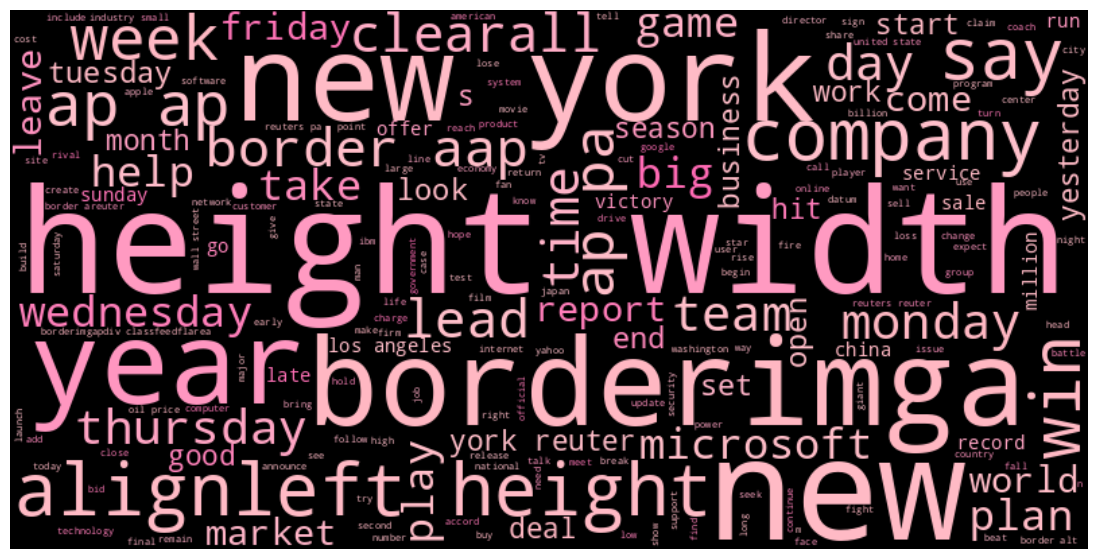

In [9]:
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap=custom_colormap).generate(' '.join([' '.join(sentence) for sentence in processed_texts]))
plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## 2.4 Text Vectorizing

### Bag of Words

In [10]:
# Vectorize the tokens using Bag of Words
cv = CountVectorizer()
bow = cv.fit_transform(data['preprocessed_text'].apply(lambda x: ' '.join(x)))
pd.DataFrame(bow.toarray(), columns=cv.get_feature_names_out()).head()

,aa,aaa,aachen,aacs,aafp,aah,aalborg,aamir,aampe,aampm,...,zurich,zvi,zvonareva,zwick,zwiesler,zwinktopia,zydrunas,zygmunt,zyprexa,zyxel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


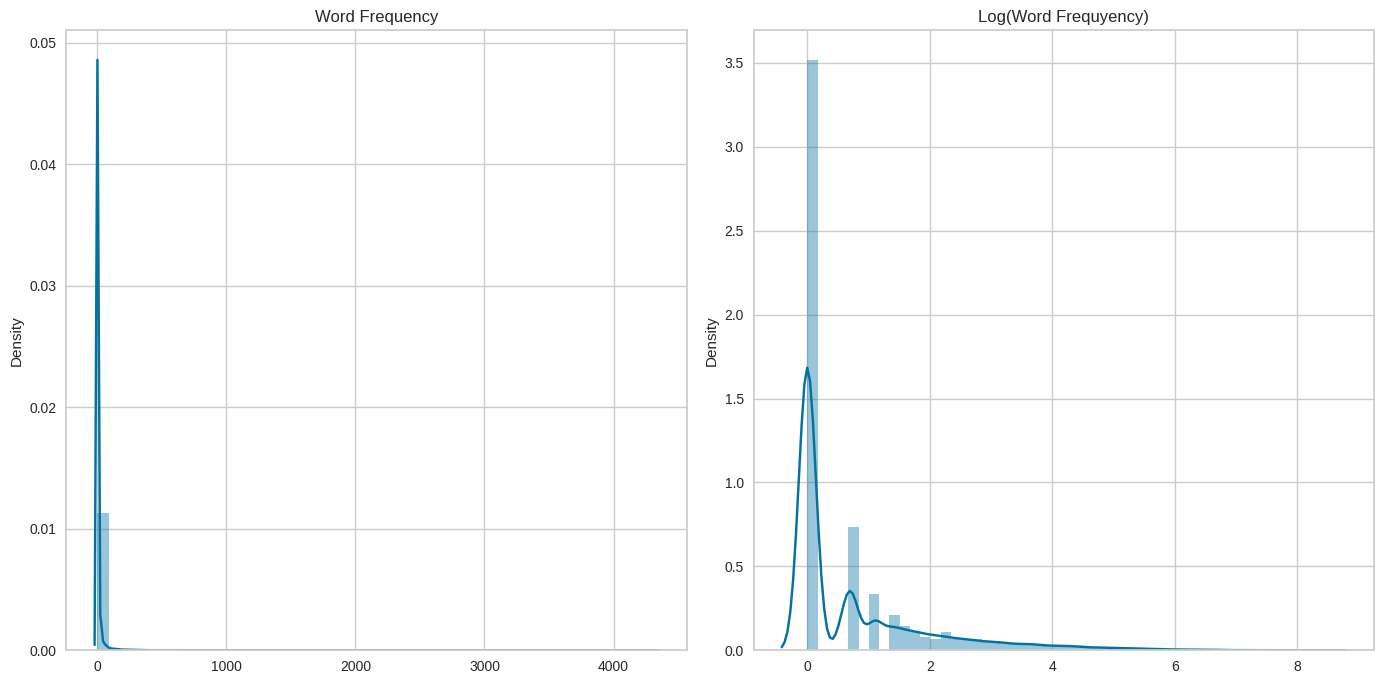

In [11]:
# Plotting word frequency
frequency = bow.sum(axis=0).A1

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.distplot(frequency, kde=True, norm_hist=True)
plt.title('Word Frequency')

plt.subplot(1, 2, 2)
sns.distplot(np.log(frequency), kde=True, norm_hist=True)
plt.title('Log(Word Frequyency)')

plt.tight_layout()
plt.show()

In [12]:
num_words = pd.DataFrame(bow.toarray(), columns=cv.get_feature_names_out()).shape[1]

print(f'Number of distinct words in this dataset: {num_words}')
print(f'Number of words that appeared more than 100 times: {len(frequency[frequency > 100])}')

Number of distinct words in this dataset: 52238
Number of words that appeared more than 100 times: 996


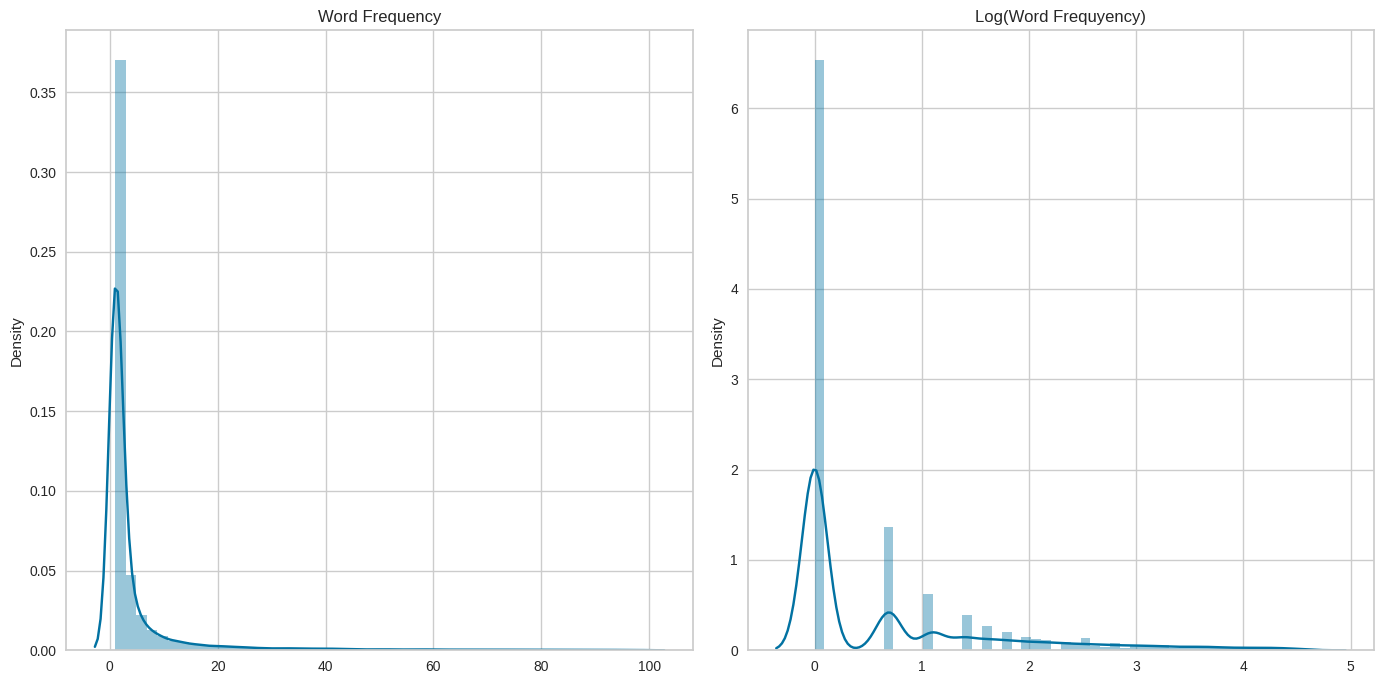

In [13]:
# Plot the frequency distribution of words for frequency < 100
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
sns.distplot(frequency[frequency < 100]  , kde=True, norm_hist=True)
plt.title('Word Frequency')

plt.subplot(1, 2, 2)
sns.distplot(np.log(frequency[frequency < 100]  ), kde=True, norm_hist=True)
plt.title('Log(Word Frequyency)')

plt.tight_layout()
plt.show()

In [14]:
print(f'Number of words that appeared less than 30 times: {len(frequency[frequency < 30])}, which is {round(len(frequency[frequency < 30])/num_words*100, 2)}% of the dataset.')
print(f'Number of words that appeared less than 5 times: {len(frequency[frequency < 5])}, which is {round(len(frequency[frequency < 5])/num_words*100, 2)}% of the dataset.')

Number of words that appeared less than 30 times: 49390, which is 94.55% of the dataset.
Number of words that appeared less than 5 times: 41949, which is 80.3% of the dataset.


Bag of Words allowed us to easily determine the frequency of words in the corpus, and from the distribution plot shows that majority of the words appear less than 30 times. Through calculation, we found that about 80.3% of the words appeared less than 5 times, and 94.55% of the words appeared less than 30 times. This may cause our future classification to underperform.

### N-gram

In [15]:
cv = CountVectorizer(ngram_range=(1, 2),min_df=0.0002)

ngram = cv.fit_transform(data['preprocessed_text'].apply(lambda x: ' '.join(x)))

ngram_df = pd.DataFrame(ngram.toarray(), columns=cv.get_feature_names_out())

ngram_df.head()

,aa,aafp,aafp world,aampm,aap,aap anna,aap barry,aap british,aap chris,aap david,...,zhang,zimbabwe,zombie,zone,zoo,zook,zoom,zucker,zurich,zvonareva
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### TF-IDF

In [16]:
# Vectorize using TF-IDF
tfidf = TfidfVectorizer(min_df = 5) # tokens appear at least 5 times to accelerate calculation
tfidf_matrix = tfidf.fit_transform(data['preprocessed_text'].apply(lambda x: ' '.join(x)))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
tfidf_df.head()

,aa,aafp,aampm,aap,aaron,ab,abandon,abbas,abbott,abby,...,zetajones,zimbabwe,zombie,zone,zoo,zook,zoom,zucker,zurich,zvonareva
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.5 Text Embedding

### Word2Vec

In [17]:
# Apply Word2Vec
word2vec = Word2Vec(sentences=data['preprocessed_text'], vector_size=100, window=2, min_count=5, workers=4)

#### Averaging

In [18]:
# Obtain the average of word embedding
def vectorizer_w2v(word2vec_model, doc_tokens):

    # Retrieve vectors for words in the vocabulary from the model
    vectors = [word2vec_model.wv[word] for word in doc_tokens if word in word2vec_model.wv.key_to_index]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Calculate the vector for each document
data['w2v_avg'] = data['preprocessed_text'].apply(lambda doc: vectorizer_w2v(word2vec, doc))
data[['preprocessed_text', 'w2v_avg']].head(1)

,preprocessed_text,w2v_avg
539103,"[microsoft, sale, mr, softy, lure, peoplesoft, customer, deep, discount, investor, not, worry]","[-0.11139341, 0.17763062, -0.053192064, 0.22409882, -0.20729452, -0.20418106, 0.78754336, 0.51029545, -0.14737839, -0.26051357, -0.072593376, -0.108177155, 0.09659543, 0.12738478, -0.14301394, -0.40237704, 0.15025216, -0.2829807, -0.13767546, -0.18462645, 0.12167342, 0.0740047, -0.13614105, -0.27734864, 0.06733876, -0.12343984, -0.12951311, -0.14094014, -0.08086371, 0.19272533, 0.38619193, 0.014089221, 0.023418529, -0.3538326, -0.30309558, 0.5130097, -0.039097995, -0.12139397, 0.085341394, -0.5549503, 0.19338466, -0.22370109, 0.04332073, -0.13378125, 0.50522065, -0.023194911, -0.19859098, 0.037549574, 0.0921212, 0.17007822, 0.10515035, -0.08929856, -0.013502505, 0.06777655, -0.38014558, 0.29285705, 0.23716396, -0.014364949, -0.5401512, 0.054461703, 0.2291225, 0.094578885, -0.2352388, -0.031442985, -0.36741006, 0.100020126, -0.20662293, -0.08671194, -0.35737455, 0.19774862, -0.56405026, 0.3371889, 0.32006294, -0.10280926, 0.43288934, -0.24240758, -0.081904, 0.07633058, -0.07262056, 0.25343755, 0.13820519, 0.09532876, -0.32852766, 0.30741584, -0.028102659, 0.08929102, -0.23694843, 0.03200218, -0.035632037, 0.26174936, 0.57110476, 0.0552555, -0.15560323, -0.11593252, 0.56571406, 0.0048102573, -0.09302275, -0.22613174, -0.05888073, -0.13090083]"


#### TF-IDF weighted averaging

In [60]:
# Create a vocabulary and word vector mapping
word2vec_vocab = set(word2vec.wv.index_to_key)
word_vector_dict = {word: word2vec.wv[word] for word in word2vec_vocab if word in tfidf.vocabulary_}

# Compute the weighted average word vector
def weighted_average_vector(document):

    # Only consider words in both Word2Vec and TF-IDF vocabularies
    valid_words = [word for word in document if word in word_vector_dict]

    if valid_words:

      # Compute TF-IDF weights and corresponding word vectors
      weights = [tfidf.idf_[tfidf.vocabulary_[word]] for word in valid_words if word in tfidf.vocabulary_]
      vectors = [word_vector_dict[word] for word in valid_words]

    else:
      # If there are no valid words in the document, return a zero vector
      return np.zeros(word2vec.vector_size)

    # Compute the weighted average
    if weights:  # Ensure weights are not empty
        weighted_average = np.dot(weights, vectors) / sum(weights)
    else:
        weighted_average = np.zeros(word2vec.vector_size)

    return weighted_average

# Apply the weighted average word vector
data['w2v_tfidf_weighted'] = [weighted_average_vector(doc) for doc in data['preprocessed_text']]
data[['preprocessed_text', 'w2v_tfidf_weighted']].head(1)

,preprocessed_text,w2v_tfidf_weighted
539103,"[microsoft, sale, mr, softy, lure, peoplesoft, customer, deep, discount, investor, not, worry]","[-0.12557655461182707, 0.17538385745966317, -0.04526718439831115, 0.19729820764803993, -0.17693555947798909, -0.21524591787727637, 0.7315669971687884, 0.50172379675276, -0.13772555792790872, -0.24211943268358976, -0.07978193440524545, -0.10527791223959111, 0.0705804924230181, 0.10081761131745315, -0.13695265166303008, -0.3766380919913327, 0.1414933684352639, -0.2495041222824177, -0.13217109991099685, -0.19155808472963884, 0.10628351877938655, 0.06625222672521222, -0.09528662979610573, -0.2545153147020932, 0.06474548540533796, -0.1139846893459789, -0.1326585659794835, -0.12886236840862375, -0.08749882965118717, 0.200803906355252, 0.36640260973761374, 0.010945284719737006, 0.03115930460872979, -0.34159833442818427, -0.2846047932152301, 0.4878884703007384, -0.036784744776664435, -0.10817848168294761, 0.07377908120188116, -0.5218478597283703, 0.1800502409815598, -0.2440870047577387, 0.035679273020626324, -0.116481061322157, 0.4660842567376659, -0.022463545738350247, -0.16634220512706324, 0.02382962523232915, 0.0944907192458305, 0.17019858126253878, 0.10953381591425304, -0.11405850340367918, -0.006486708228908707, 0.05372008415715654, -0.38216246691444866, 0.27738207188017583, 0.22874003733833706, -0.026302415534402553, -0.5084281221620929, 0.05672730811176531, 0.23675094182862097, 0.08952972418166076, -0.20784875444382125, -0.0392396418584397, -0.3391043437982309, 0.11447245242456465, -0.17706452242848916, -0.05708461835024923, -0.3619294782181363, 0.19098146167532026, -0.5281705729059145, 0.3210244821824302, 0.3082886809066013, -0.09439488796869497, 0.3981124923424942, -0.20743988871639815, -0.10206305547785098, 0.07979708749950948, -0.0760899781515027, 0.23717232147764028, 0.12138154398218892, 0.10330152388614491, -0.3134575314634037, 0.28437246166249136, -0.019714164041307942, 0.06848517055478281, -0.2119464158611326, 0.03985252879560268, -0.02359611296920134, 0.24148989673462345, 0.56606300510821, 0.06475591845985935, -0.15010889122134857, -0.11615223120870129, 0.5500522511011084, -0.013922542780360982, -0.07832080979228354, -0.21008993482316765, -0.07406045493545042, -0.13408624556586887]"


In [33]:
# Create a vocabulary and word vector mapping
word2vec_vocab = set(word2vec.wv.index_to_key)
word_vector_dict = {word: word2vec.wv[word] for word in word2vec_vocab if word in tfidf.vocabulary_}

# Compute TF-IDF weights and corresponding word vectors
tfidf_weights = {word: tfidf.idf_[idx] for word, idx in tfidf.vocabulary_.items()}

# Compute the weighted average word vector
def weighted_average_vector(document, word_vector_dict, tfidf_weights):
    valid_words = [word for word in document if word in word_vector_dict]

    # If there are no valid words in the document, return a zero vector
    if not valid_words:
        return np.zeros(word2vec.vector_size)

    # Compute weights and vectors based on valid words
    weights = np.array([tfidf_weights[word] for word in valid_words])
    vectors = np.array([word_vector_dict[word] for word in valid_words])

    # Compute the weighted average
    weighted_average = np.average(vectors, axis=0, weights=weights)
    return weighted_average

# Apply the weighted average word vector
data['w2v_tfidf_weighted'] = [weighted_average_vector(doc, word_vector_dict, tfidf_weights) for doc in data['preprocessed_text']]
data[['preprocessed_text', 'w2v_tfidf_weighted']].head(1)

,preprocessed_text,w2v_tfidf_weighted
539103,"[microsoft, sale, mr, softy, lure, peoplesoft, customer, deep, discount, investor, not, worry]","[-0.12557655461182712, 0.17538385745966317, -0.04526718439831115, 0.19729820764803996, -0.1769355594779891, -0.21524591787727637, 0.7315669971687884, 0.50172379675276, -0.13772555792790872, -0.24211943268358982, -0.07978193440524545, -0.10527791223959111, 0.07058049242301812, 0.10081761131745316, -0.1369526516630301, -0.37663809199133275, 0.1414933684352639, -0.2495041222824177, -0.13217109991099685, -0.19155808472963884, 0.10628351877938658, 0.06625222672521222, -0.09528662979610575, -0.2545153147020932, 0.06474548540533796, -0.11398468934597893, -0.1326585659794835, -0.12886236840862375, -0.08749882965118717, 0.200803906355252, 0.3664026097376138, 0.010945284719737013, 0.031159304608729798, -0.3415983344281842, -0.28460479321523, 0.4878884703007384, -0.036784744776664435, -0.10817848168294764, 0.07377908120188116, -0.5218478597283703, 0.1800502409815598, -0.24408700475773867, 0.035679273020626324, -0.116481061322157, 0.46608425673766596, -0.022463545738350247, -0.16634220512706324, 0.023829625232329156, 0.0944907192458305, 0.1701985812625388, 0.10953381591425305, -0.11405850340367918, -0.006486708228908709, 0.05372008415715651, -0.3821624669144486, 0.27738207188017583, 0.22874003733833706, -0.02630241553440256, -0.5084281221620929, 0.0567273081117653, 0.23675094182862097, 0.08952972418166076, -0.20784875444382125, -0.03923964185843972, -0.33910434379823085, 0.11447245242456466, -0.17706452242848914, -0.05708461835024923, -0.36192947821813637, 0.1909814616753203, -0.5281705729059146, 0.3210244821824302, 0.3082886809066012, -0.09439488796869497, 0.3981124923424942, -0.20743988871639818, -0.10206305547785098, 0.07979708749950948, -0.0760899781515027, 0.2371723214776403, 0.12138154398218894, 0.10330152388614491, -0.3134575314634037, 0.28437246166249136, -0.019714164041307942, 0.06848517055478281, -0.21194641586113264, 0.03985252879560267, -0.02359611296920134, 0.24148989673462348, 0.56606300510821, 0.06475591845985935, -0.15010889122134857, -0.1161522312087013, 0.5500522511011084, -0.013922542780360982, -0.07832080979228358, -0.21008993482316765, -0.07406045493545042, -0.13408624556586884]"


### Doc2Vec

In [20]:
# Create a list of documents where each document is represented by a TaggedDocument object

# Instantiate the model
d2v = Doc2Vec([TaggedDocument(doc, [i]) for i, doc in enumerate(data['preprocessed_text'])], vector_size=100, window=2, min_count=0.0002, workers=4)

# retrieve vectors from the model
data['doc2vec'] = [d2v.infer_vector(doc) for doc in data['preprocessed_text']]

data[['preprocessed_text', 'doc2vec']].head(1)

,preprocessed_text,doc2vec
539103,"[microsoft, sale, mr, softy, lure, peoplesoft, customer, deep, discount, investor, not, worry]","[-0.022152705, 0.008150541, 0.010440277, 0.052571505, 0.023285607, 0.063701406, 0.03437717, -0.057560135, -0.11160186, -0.046107315, -0.02634797, 0.011414345, -0.018144257, 0.019900454, 0.07896435, -0.015908122, 0.021451969, -0.08650484, 0.08798439, -0.02937643, 0.07694306, -0.030621685, -0.059163656, -0.03935945, -0.04176669, -0.056880336, 0.021809118, 0.030281637, 0.05712989, -0.032216728, 0.07286096, -0.056856755, 0.014517989, 0.04080631, 0.029195465, 0.031353824, -0.06541772, 0.034398407, 0.008151463, -0.015806895, 0.04816565, -0.032117955, -0.012598481, 0.09711953, 0.009678217, 0.042389188, 0.073720634, -0.055495385, 0.0036505302, -0.04432683, 0.042683743, -0.0033466383, 0.079500556, 0.111115284, 0.07317452, 0.057727676, -0.040777203, 0.057046372, -0.0040470245, 0.04004636, 0.015259807, 0.039218746, -0.12977852, -0.0018387565, -0.013890889, -0.105831854, -0.02315025, -0.014240444, 0.043170333, -0.024649387, -0.084685735, 0.038683638, 0.081754856, 0.036428288, 0.067692034, -0.016013939, -0.05975786, -0.0021261123, 0.15388855, -0.044536535, 0.00088293466, -0.026885144, -0.04155965, -0.0116207665, -0.019047063, -0.009686698, -0.09351271, -0.08358065, 0.03354789, -0.018146781, 0.022667123, -0.050916642, -0.050570644, -0.03793101, 0.019964527, -0.0015164397, -0.07435013, -0.10328163, -0.024325503, -0.071641244]"


### GloVe

In [21]:
'''
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip glove.6B.100d.txt
# Load GloVe from their webisite and unzip
'''

'\n!wget http://nlp.stanford.edu/data/glove.6B.zip\n!unzip glove.6B.zip glove.6B.100d.txt\n# Load GloVe from their webisite and unzip\n'

Uncomment the above cell to download and unzip GloVe if not yet installed.

In [22]:
# Load and generate GloVe embeddings
def load_glove_embeddings(path):
    embeddings_dict = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
    return embeddings_dict

# Use
glove_path = 'glove.6B.100d.txt'
embeddings_dict = load_glove_embeddings(glove_path)

In [23]:
# Vectorize every token and get the mean of them
def tokens_to_vector(tokens, embeddings_dict, vector_size=50):
    vectors = [embeddings_dict.get(word, np.zeros(vector_size)) for word in tokens]
    if vectors:
        return np.mean(np.array(vectors), axis=0).tolist()
    else:
        return np.zeros(vector_size).tolist()

data['glove'] = data['preprocessed_text'].apply(lambda x: tokens_to_vector(x, embeddings_dict, vector_size=100))

In [24]:
data[['preprocessed_text', 'glove']].head(1)

,preprocessed_text,glove
539103,"[microsoft, sale, mr, softy, lure, peoplesoft, customer, deep, discount, investor, not, worry]","[0.09471195191144943, 0.14179308712482452, 0.20085258781909943, -0.054445501416921616, -0.07332908362150192, -0.29959169030189514, -0.19374601542949677, -0.3639158308506012, 0.09347790479660034, -0.13745148479938507, -0.015296337194740772, 0.35242021083831787, 0.1275806725025177, -0.40630611777305603, 0.007570842746645212, -0.1952715963125229, -0.14842157065868378, 0.2640421688556671, -0.08075734227895737, 0.4517643451690674, -0.04098746180534363, 0.06597166508436203, -0.12083617597818375, -0.022701583802700043, 0.008615043945610523, 0.08441764116287231, -0.0833650752902031, -0.18128831684589386, -0.30170688033103943, -0.18268835544586182, 0.2324649840593338, 0.67718106508255, -0.14090250432491302, -0.19485728442668915, 0.1260378211736679, 0.4256674349308014, 0.16813957691192627, -0.030872410163283348, 0.17113500833511353, -0.3286386728286743, 0.046077337116003036, -0.296101838350296, 0.10184208303689957, -0.16187776625156403, -0.13147008419036865, 0.1513022482395172, -0.028127571567893028, -0.07343707978725433, 0.14429841935634613, -0.4674849808216095, 0.17928357422351837, 0.08653634041547775, -0.011032362468540668, 0.15097808837890625, -0.010846582241356373, -1.3604100942611694, -0.08839897066354752, -0.43571504950523376, 1.2221198081970215, -0.05268726125359535, 0.08151174336671829, 0.009684339165687561, -0.19353057444095612, 0.26202622056007385, 0.262714147567749, -0.004048993345350027, 0.47961553931236267, 0.2645544707775116, 0.29376301169395447, -0.1748371124267578, 0.028056247159838676, -0.06833750754594803, -0.27031373977661133, -0.38615918159484863, -0.21856291592121124, 0.15747833251953125, 0.023546254262328148, -0.15153025090694427, -0.6154641509056091, 0.07902558892965317, 0.5297341346740723, -0.3258022367954254, -0.3380533754825592, 0.08129190653562546, -0.7496959567070007, -0.4769306182861328, -0.012756670825183392, 0.11981963366270065, -0.16506890952587128, -0.2958768904209137, -0.059469494968652725, 0.2607848346233368, 0.005971913691610098, -0.20140916109085083, -0.012293323874473572, 0.13967199623584747, 0.150369331240654, -0.11474939435720444, 0.2885212004184723, 0.21042348444461823]"


## 2.6 Clustering

In [25]:
# Perform dimensionality reduction on the TF-IDF matrix directly
dim_red = PCA(n_components=3, random_state=42)
embeddings_for_visualization = dim_red.fit_transform(tfidf_df)

# Convert the reduced embeddings into a DataFrame
df = pd.DataFrame(embeddings_for_visualization, columns=['x', 'y', 'z'])
# Create a scatter plot using Plotly
fig = px.scatter_3d(df, x='x', y='y', z='z', title='TF-IDF Visualization')
fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(showlegend=False)
fig.show()

In [26]:
# Define the number of clusters
num_clusters = 4  # You can adjust this number as needed

# Initialize KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans to the TF-IDF embeddings
kmeans.fit(tfidf_matrix)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Add cluster labels to the DataFrame
df['cluster'] = cluster_labels

# Visualize the clusters
fig = px.scatter_3d(df, x='x', y='y', z='z', color='cluster', title='TF-IDF Clustering')
fig.update_traces(marker=dict(size=8, opacity=0.8, line=dict(width=1, color='DarkSlateGrey')))
fig.update_layout(showlegend=True)
fig.show()

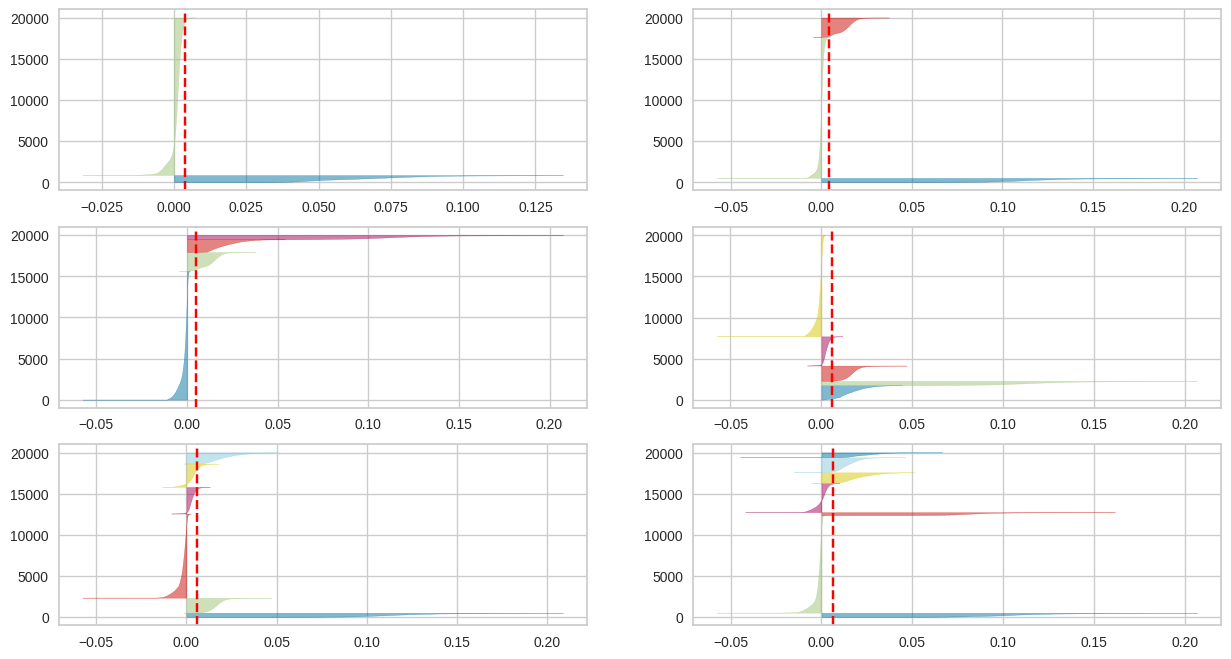

In [27]:
#Larger Silhouette score is better
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5,6,7]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(tfidf_matrix)

From the 3D graphs ploted above, it appears that there are two clusters and they are quite distant. On the other hand, the silhouette plots for do not suggest any cluster. We plotted the silhouette scores for up to 20 clusters, and the score shows an upward trend and it will get even higher if number of clusters increases. To save computational space, we threw away that graph. Therefore, we will proceed with other methods.

# 3.Model Building

In this part, we first use RandomForestClassifier to build model based on different vectorizing methods we used in part2, and we will check the accuracy score of these models. By comparing the accuracy score, we will decide one vectorizing matrix to apply different classification functions.

We purposefully avoid defining X and y for each model to save computational space.

## 3.1 Random Forest

### N-gram

In [28]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(ngram_df, data['category'], test_size=0.2, random_state=42)

# from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred = rf_classifier.predict(X_test)
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.70      0.83      0.76       995
Entertainment       0.75      0.64      0.69      1024
     Sci/Tech       0.80      0.68      0.73       977
       Sports       0.82      0.91      0.86      1004

     accuracy                           0.76      4000
    macro avg       0.77      0.76      0.76      4000
 weighted avg       0.77      0.76      0.76      4000



### TF-IDF

In [29]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'].apply(lambda x: ' '.join(x)), data['category'], test_size=0.2, random_state=42)

# Vectorize X_train and X_test seperately
tfidf = TfidfVectorizer(min_df = 5)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.72      0.80      0.76       995
Entertainment       0.72      0.65      0.68      1024
     Sci/Tech       0.77      0.69      0.73       977
       Sports       0.81      0.91      0.86      1004

     accuracy                           0.76      4000
    macro avg       0.76      0.76      0.76      4000
 weighted avg       0.76      0.76      0.76      4000



### W2V average

In [30]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data['w2v_avg'].to_list(), data['category'], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.72      0.70      0.71       995
Entertainment       0.58      0.57      0.58      1024
     Sci/Tech       0.65      0.62      0.63       977
       Sports       0.73      0.79      0.76      1004

     accuracy                           0.67      4000
    macro avg       0.67      0.67      0.67      4000
 weighted avg       0.67      0.67      0.67      4000



### W2V TF-IDF weighted average

In [34]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data['w2v_tfidf_weighted'].to_list(), data['category'], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.71      0.70      0.71       995
Entertainment       0.60      0.59      0.59      1024
     Sci/Tech       0.67      0.61      0.64       977
       Sports       0.74      0.82      0.78      1004

     accuracy                           0.68      4000
    macro avg       0.68      0.68      0.68      4000
 weighted avg       0.68      0.68      0.68      4000



### Doc2Vec

In [35]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data['doc2vec'].to_list(), data['category'], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.69      0.75      0.72       995
Entertainment       0.61      0.61      0.61      1024
     Sci/Tech       0.66      0.60      0.63       977
       Sports       0.81      0.83      0.82      1004

     accuracy                           0.70      4000
    macro avg       0.69      0.70      0.69      4000
 weighted avg       0.69      0.70      0.69      4000



### GloVe

In [36]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(np.vstack(data['glove'].values), data['category'], test_size=0.2, random_state=42)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
glove_rf_pred = rf.predict(X_test)
print(classification_report(y_test, glove_rf_pred))

               precision    recall  f1-score   support

     Business       0.80      0.78      0.79       995
Entertainment       0.74      0.70      0.72      1024
     Sci/Tech       0.72      0.76      0.74       977
       Sports       0.89      0.92      0.91      1004

     accuracy                           0.79      4000
    macro avg       0.79      0.79      0.79      4000
 weighted avg       0.79      0.79      0.79      4000



After building these models, we found that classification model with tfidf matrix has the best accuracy score. Thus in the following steps, we will choose the vectors transformed by tfidf to apply other classifiers and find out the model that suits our dataset best.

## 3.2 Naive Bayes

### TF-IDF

In [37]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'].apply(lambda x: ' '.join(x)), data['category'], test_size=0.2, random_state=42)

# Vectorize X_train and X_test seperately
tfidf = TfidfVectorizer(min_df = 5)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

nb = GaussianNB()
nb.fit(X_train_dense, y_train)

y_pred = nb.predict(X_test_dense)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.58      0.81      0.68       995
Entertainment       0.65      0.47      0.55      1024
     Sci/Tech       0.68      0.58      0.63       977
       Sports       0.80      0.84      0.82      1004

     accuracy                           0.67      4000
    macro avg       0.68      0.67      0.67      4000
 weighted avg       0.68      0.67      0.67      4000



### GloVe

In [38]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(np.vstack(data['glove'].values), data['category'], test_size=0.2, random_state=42)

nb = GaussianNB()
nb.fit(X_train, y_train)
glove_nb_pred = nb.predict(X_test)
print(classification_report(y_test, glove_nb_pred))

               precision    recall  f1-score   support

     Business       0.78      0.70      0.74       995
Entertainment       0.66      0.70      0.68      1024
     Sci/Tech       0.67      0.71      0.69       977
       Sports       0.89      0.89      0.89      1004

     accuracy                           0.75      4000
    macro avg       0.75      0.75      0.75      4000
 weighted avg       0.75      0.75      0.75      4000



## 3.3 Logistic Regression

### TF-IDF

In [39]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'].apply(lambda x: ' '.join(x)), data['category'], test_size=0.2, random_state=42)

# Vectorize X_train and X_test seperately
tfidf = TfidfVectorizer(min_df = 5)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.80      0.78      0.79       995
Entertainment       0.76      0.71      0.74      1024
     Sci/Tech       0.77      0.80      0.78       977
       Sports       0.89      0.93      0.91      1004

     accuracy                           0.81      4000
    macro avg       0.80      0.81      0.80      4000
 weighted avg       0.80      0.81      0.80      4000



### GloVe

In [40]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(np.vstack(data['glove'].values), data['category'], test_size=0.2, random_state=42)

lr = LogisticRegression()
lr.fit(X_train, y_train)
glove_lr_pred = lr.predict(X_test)
print(classification_report(y_test, glove_lr_pred))

               precision    recall  f1-score   support

     Business       0.79      0.77      0.78       995
Entertainment       0.75      0.70      0.73      1024
     Sci/Tech       0.73      0.78      0.76       977
       Sports       0.89      0.92      0.91      1004

     accuracy                           0.79      4000
    macro avg       0.79      0.79      0.79      4000
 weighted avg       0.79      0.79      0.79      4000



## 3.4 XGBoost

### TF-IDF

In [41]:
# Use label encoder to encode y since it is categorical
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['category'])

# Train test split
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'].apply(lambda x: ' '.join(x)), y_encoded, test_size=0.2, random_state=42)

# Vectorize X_train and X_test seperately
tfidf = TfidfVectorizer(min_df = 5)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       995
           1       0.67      0.70      0.69      1024
           2       0.77      0.73      0.75       977
           3       0.85      0.88      0.87      1004

    accuracy                           0.76      4000
   macro avg       0.77      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



### GloVe

In [42]:
# Apply label encoder on y
encoder = LabelEncoder()
y = encoder.fit_transform(data['category'])

X_train, X_test, y_train, y_test = train_test_split(np.vstack(data['glove'].values), y, test_size=0.2, random_state=42)

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
glove_xgb_pred = xgb.predict(X_test)
print(classification_report(y_test, glove_xgb_pred))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       995
           1       0.79      0.69      0.74      1024
           2       0.74      0.80      0.77       977
           3       0.89      0.94      0.91      1004

    accuracy                           0.80      4000
   macro avg       0.80      0.80      0.80      4000
weighted avg       0.80      0.80      0.80      4000



## 3.5 SVM

### TF-IDF

In [43]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'].apply(lambda x: ' '.join(x)), data['category'], test_size=0.2, random_state=42)

# Vectorize X_train and X_test seperately
tfidf = TfidfVectorizer(min_df = 5)
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

svm = SVC(random_state=42, kernel='rbf', class_weight='balanced', probability=True)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

     Business       0.82      0.79      0.80       995
Entertainment       0.77      0.73      0.75      1024
     Sci/Tech       0.78      0.82      0.80       977
       Sports       0.90      0.93      0.91      1004

     accuracy                           0.82      4000
    macro avg       0.82      0.82      0.82      4000
 weighted avg       0.82      0.82      0.82      4000



### GloVe

In [44]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(np.vstack(data['glove'].values), data['category'], test_size=0.2, random_state=42)

svm = SVC(random_state=42, kernel='rbf', class_weight='balanced', probability=True)
svm.fit(X_train, y_train)
glove_svm_pred = svm.predict(X_test)
print(classification_report(y_test, glove_svm_pred))

               precision    recall  f1-score   support

     Business       0.80      0.79      0.80       995
Entertainment       0.81      0.69      0.74      1024
     Sci/Tech       0.74      0.82      0.78       977
       Sports       0.89      0.95      0.92      1004

     accuracy                           0.81      4000
    macro avg       0.81      0.81      0.81      4000
 weighted avg       0.81      0.81      0.81      4000



By running different models from 3.1 to 3.5, as we have expected, GloVe's embedding generated stable and the generally better results, the average of its classifiation is mostly around 0.8  Since majority of words in the corpus appeared for only a few times and we created our vectorization/embedding and trained the models on a limited amount of data, a pre-trained NLP model would work better in most cases. Nevertheless, the highest accuracy across all models and methods was achieved by TF-IDF in SVM

Furthermore, we found that in all the methods and models we have tried, the classification for Sports news performed the best among all four categories.

# 4.Deep Learning

### Transfer Learning with LSTM

1. convert each document into vector sequence

In [45]:
# Define a function to convert each document in data into vector sequence
def doc_to_vector_sequence(doc, word2vec_model):
    vector_sequence = []
    for word in doc:
        if word in word2vec_model.wv:
            vector_sequence.append(word2vec_model.wv[word])
        else:
            # Use zeros if not in the vocabulary
            vector_sequence.append(np.zeros(word2vec_model.vector_size))
    return np.array(vector_sequence)

# Apply function
vector_sequences = [doc_to_vector_sequence(doc, word2vec) for doc in data['preprocessed_text']]

# Verify the result
print(vector_sequences[0].shape)
vector_sequences[0]

(12, 100)


array([[ 0.44809666,  0.34530133,  0.00612449, ..., -0.78096294,
        -0.09793447, -0.18010327],
       [ 0.64510334, -0.02407786, -0.14124571, ...,  0.10388358,
        -0.23621103, -0.24393699],
       [-0.35870969,  0.22730912,  0.02712343, ..., -0.17857458,
        -0.0351239 , -0.13834634],
       ...,
       [-0.08534512,  0.16101742, -0.07394603, ..., -0.18728675,
        -0.34961501, -0.24718571],
       [-0.81196952,  0.20609498, -0.151537  , ..., -0.31263953,
         0.66728508,  0.20383081],
       [-0.20871942,  0.16603428,  0.03310162, ..., -0.06952247,
        -0.37326428, -0.24102421]])

2. **padding**

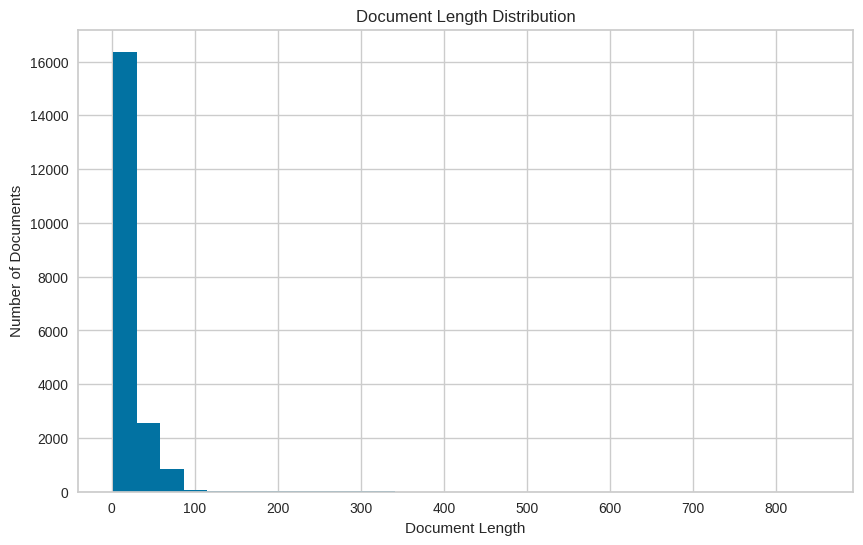

In [46]:
# Visualize document length distrib
doc_lengths = [len(doc) for doc in data['preprocessed_text']]

plt.figure(figsize=(10, 6))
plt.hist(doc_lengths, bins=30)
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Number of Documents')
plt.xticks(range(0, max(doc_lengths) + 1, 100))
plt.show()

In [47]:
np.quantile(doc_lengths, 0.99)

89.0

look like maxlen = 90 should be a good choice

In [48]:
# Pad the sequence
padded_sequences = pad_sequences(vector_sequences, maxlen=90, dtype='float32', padding='post', truncating='post')

# Verify the result
print(padded_sequences[0].shape)
padded_sequences[0]

(90, 100)


array([[ 0.44809666,  0.34530133,  0.00612449, ..., -0.78096294,
        -0.09793447, -0.18010327],
       [ 0.64510334, -0.02407786, -0.14124571, ...,  0.10388358,
        -0.23621103, -0.24393699],
       [-0.3587097 ,  0.22730912,  0.02712343, ..., -0.17857458,
        -0.0351239 , -0.13834634],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

4. train test split

In [49]:
# One-hot encode target
y = pd.get_dummies(data['category']).values
X = padded_sequences

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
print(y)

(20000, 90, 100)
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]]


In [50]:
sequence_len = X.shape[1]
embedding_dim = X.shape[2]

# Build model
model = Sequential()

# Add a convolution layer to do feature selection
model.add(Conv1D(filters=128, kernel_size=5, activation='relu', input_shape=(sequence_len, embedding_dim)))
model.add(MaxPooling1D(pool_size=4))

# Sequential modeling using LSTM
model.add(LSTM(64))

# Output layer with 4 nuerons and softmax for muti-classification problem
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 86, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 21, 128)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 113796 (444.52 KB)
Trainable params: 113796 (444.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
%%time
K.clear_session()
# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
200/200 [==============================] - 26s 110ms/step - loss: 1.0288 - accuracy: 0.5623 - val_loss: 0.8980 - val_accuracy: 0.6363
Epoch 2/10
200/200 [==============================] - 17s 83ms/step - loss: 0.8397 - accuracy: 0.6652 - val_loss: 0.7956 - val_accuracy: 0.6837
Epoch 3/10
200/200 [==============================] - 18s 88ms/step - loss: 0.7840 - accuracy: 0.6920 - val_loss: 0.7709 - val_accuracy: 0.6909
Epoch 4/10
200/200 [==============================] - 19s 94ms/step - loss: 0.7433 - accuracy: 0.7074 - val_loss: 0.7843 - val_accuracy: 0.6897
Epoch 5/10
200/200 [==============================] - 19s 94ms/step - loss: 0.7106 - accuracy: 0.7232 - val_loss: 0.7313 - val_accuracy: 0.7116
Epoch 6/10
200/200 [==============================] - 18s 93ms/step - loss: 0.6905 - accuracy: 0.7366 - val_loss: 0.7665 - val_accuracy: 0.7028
Epoch 7/10
200/200 [==============================] - 18s 91ms/step - loss: 0.6768 - accuracy: 0.7384 - val_loss: 0.7270 - val_accuracy

In [52]:
prediction = model.predict(X_test)

# Map one-hot encoded y to origin values
cat_names = pd.get_dummies(data['category']).columns.tolist()
y_pred_label = [cat_names[i] for i in np.argmax(prediction, axis=1)]
y_test_label = [cat_names[i] for i in np.argmax(y_test, axis=1)]

print(classification_report(y_test_label, y_pred_label))

125/125 [==============================] - 3s 20ms/step
               precision    recall  f1-score   support

     Business       0.71      0.79      0.75       995
Entertainment       0.69      0.57      0.62      1024
     Sci/Tech       0.72      0.65      0.69       977
       Sports       0.77      0.89      0.82      1004

     accuracy                           0.72      4000
    macro avg       0.72      0.72      0.72      4000
 weighted avg       0.72      0.72      0.72      4000



### Regular LSTM

In [53]:
# Get vocabulary size
text = data['preprocessed_text']
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
word_index = tokenizer.word_index
vocab_size = len(word_index)
vocab_size

52263

In [54]:
# Set parameters
vocab_size = int(vocab_size*0.99)
embedding_dim = 100
sequence_len = 90

# Preprocessing text
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>') # '<OOV>' reserves a special index for tokens not in vocabulary list
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
X = pad_sequences(sequences, maxlen=sequence_len, padding='post', truncating='post')
y = pd.get_dummies(data['category']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = Sequential()

# Add an embedding layer to covert sparse to dense matrix
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_len))

# Add a convolution layer to do feature selection
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))

# Sequential modeling using LSTM
model.add(LSTM(64))

# Output layer with 4 nuerons and softmax for muti-classification problem
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 90, 100)           5174000   
                                                                 
 conv1d (Conv1D)             (None, 86, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 21, 128)           0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 5287796 (20.17 MB)
Trainable params: 5287796 (20.17 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [55]:
%%time
K.clear_session()
# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
200/200 [==============================] - 45s 208ms/step - loss: 1.0105 - accuracy: 0.5308 - val_loss: 0.6656 - val_accuracy: 0.7450
Epoch 2/10
200/200 [==============================] - 43s 215ms/step - loss: 0.4591 - accuracy: 0.8433 - val_loss: 0.5699 - val_accuracy: 0.8091
Epoch 3/10
200/200 [==============================] - 44s 222ms/step - loss: 0.2255 - accuracy: 0.9344 - val_loss: 0.6548 - val_accuracy: 0.7825
Epoch 4/10
200/200 [==============================] - 43s 216ms/step - loss: 0.1276 - accuracy: 0.9653 - val_loss: 0.7563 - val_accuracy: 0.7772
Epoch 5/10
200/200 [==============================] - 43s 217ms/step - loss: 0.0828 - accuracy: 0.9804 - val_loss: 0.8670 - val_accuracy: 0.7772
Epoch 6/10
200/200 [==============================] - 39s 197ms/step - loss: 0.0535 - accuracy: 0.9884 - val_loss: 1.0554 - val_accuracy: 0.7619
Epoch 7/10
200/200 [==============================] - 44s 219ms/step - loss: 0.0454 - accuracy: 0.9898 - val_loss: 1.0077 - val_ac

In [56]:
prediction = model.predict(X_test)

# Map one-hot encoded y to origin values
cat_names = pd.get_dummies(data['category']).columns.tolist()
y_pred_label = [cat_names[i] for i in np.argmax(prediction, axis=1)]
y_test_label = [cat_names[i] for i in np.argmax(y_test, axis=1)]

print(classification_report(y_test_label, y_pred_label))

125/125 [==============================] - 3s 14ms/step
               precision    recall  f1-score   support

     Business       0.78      0.72      0.75       995
Entertainment       0.67      0.69      0.68      1024
     Sci/Tech       0.76      0.72      0.74       977
       Sports       0.83      0.90      0.87      1004

     accuracy                           0.76      4000
    macro avg       0.76      0.76      0.76      4000
 weighted avg       0.76      0.76      0.76      4000



### Simple RNN

In [57]:
# Set parameters
vocab_size = int(vocab_size*0.99)
embedding_dim = 100
sequence_len = 90

# Preprocessing text
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>') # '<OOV>' reserves a special index for tokens not in vocabulary list
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text)
X = pad_sequences(sequences, maxlen=sequence_len, padding='post', truncating='post')
y = pd.get_dummies(data['category']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build model
model = Sequential()

# Add an embedding layer to covert sparse to dense matrix
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_len))

# Add a convolution layer to do feature selection
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))

# Sequential modeling using LSTM
model.add(SimpleRNN(64))

# Output layer with 4 nuerons and softmax for muti-classification problem
model.add(Dense(4, activation='softmax'))

# Compile
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 90, 100)           5122200   
                                                                 
 conv1d (Conv1D)             (None, 86, 128)           64128     
                                                                 
 max_pooling1d (MaxPooling1  (None, 21, 128)           0         
 D)                                                              
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 5198940 (19.83 MB)
Trainable params: 5198940 (19.83 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [58]:
%%time
K.clear_session()
# Train the model
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.2, verbose=1)

Epoch 1/10
200/200 [==============================] - 46s 213ms/step - loss: 0.9097 - accuracy: 0.6186 - val_loss: 0.6830 - val_accuracy: 0.7466
Epoch 2/10
200/200 [==============================] - 37s 186ms/step - loss: 0.2728 - accuracy: 0.9123 - val_loss: 0.7942 - val_accuracy: 0.7437
Epoch 3/10
200/200 [==============================] - 37s 186ms/step - loss: 0.0524 - accuracy: 0.9863 - val_loss: 0.9892 - val_accuracy: 0.7278
Epoch 4/10
200/200 [==============================] - 38s 192ms/step - loss: 0.0182 - accuracy: 0.9959 - val_loss: 1.1084 - val_accuracy: 0.7175
Epoch 5/10
200/200 [==============================] - 38s 190ms/step - loss: 0.0109 - accuracy: 0.9971 - val_loss: 1.0883 - val_accuracy: 0.7328
Epoch 6/10
200/200 [==============================] - 35s 176ms/step - loss: 0.0081 - accuracy: 0.9977 - val_loss: 1.1761 - val_accuracy: 0.7387
Epoch 7/10
200/200 [==============================] - 38s 192ms/step - loss: 0.0059 - accuracy: 0.9979 - val_loss: 1.2709 - val_ac

In [59]:
prediction = model.predict(X_test)

# Map one-hot encoded y to origin values
cat_names = pd.get_dummies(data['category']).columns.tolist()
y_pred_label = [cat_names[i] for i in np.argmax(prediction, axis=1)]
y_test_label = [cat_names[i] for i in np.argmax(y_test, axis=1)]

print(classification_report(y_test_label, y_pred_label))

125/125 [==============================] - 2s 16ms/step
               precision    recall  f1-score   support

     Business       0.71      0.73      0.72       995
Entertainment       0.58      0.62      0.60      1024
     Sci/Tech       0.73      0.65      0.69       977
       Sports       0.78      0.79      0.78      1004

     accuracy                           0.70      4000
    macro avg       0.70      0.70      0.70      4000
 weighted avg       0.70      0.70      0.70      4000



Assessing the classification reports from deep learning, the performance result was below expectation and supervised learning provided better results. The size of our dataset may be too small for deep learning methods to effectively produce accurate classification.

# 5. Conclusion

In this comprehensive study of text classification, we have applied various NLP techniques and employed severl machine learning models. After experiment of all the methods, the best result was produced by SVM and TF-IDF, and GloVe embedding provides best average results. Despite the challenges of dataset change and the limited computational space, we were able to identify the acceptable methods and models that can be applied to real world.  Analyzing news titles and descriptions facilitates sentiment analysis, trend analysis, and risk assessment, enabling businesses to gain insights into public perception, identify emerging industry trends, and anticipate potential threats or crises. These capabilities empower organizations to make informed decisions and strategic adjustments, enhancing their competitive edge and mitigating risks effectively. If there is no computational restrictions and more samples were used, the performance of models may be even better.